## A Cut Above The Rest
### Analyzing the Impact of Shot Detection Algorithms on the Quality of Chunk Encoded Videos.

Sike Ogieva, Amherst College '25.

---

This project examines the effect of shot detection methods on the resultant quality of a chunk encoded video. We want to know whether more sophisticated techniques like edge change ratio (ECR) and PySceneDetect significantly improve video quality over more simpler approaches such as  the sum of absolute differences (SAD) and the histogram differences (HD). We measure video quality with Video Multi-method Assessment Fusion (VMAF) scores.

**Abstract:**  
https://docs.google.com/document/d/1yIVvN1g7RddtsDCcZColgJstN2XduXLImbrMK0EVYxA/

In [ ]:
# !pip install scenedetect[opencv] --upgrade
# !pip install ffmpeg scikit-video

### Video Files and Frames

The bikes video from the skvideo library is around ten seconds long and was specifically designed for scene detection testing.
A video can be represented as a three-dimensional array of integers in the range (0 to 225). In preparation for later steps, we slice the video into frames, that is, into its two-dimensional arrays.

In [1]:
# video file
import skvideo.datasets

# video = skvideo.datasets.bigbuckbunny()
video = skvideo.datasets.bikes()

In [2]:
# extract frames from video
import cv2

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

frames = extract_frames(video)

In [3]:
# video shape
n_frames= len(frames)
shape   = frames[0].shape
height  = shape[0]
width   = shape[1]
channel = shape[2]

print("Shape of this video is:")
print(f"frames: {n_frames}, height: {height}, width: {width}, channels: {channel}.")

Shape of this video is:
frames: 250, height: 272, width: 640, channels: 3.


### Shot Detection Methods

***Shot Detection with SAD***  

The sum of absolute differences (SAD) is both the most obvious and most simple algorithm of all.  
The two consecutive frames are compared pixel by pixel, summing up the absolute values of the differences of each two corresponding pixels.  
SAD is very sensitive to even minor scene changes and catches hard cuts very well, but is likely to miss out on softer cuts.

Here, we find all the SAD scores between frames and find the peaks (the points where the largest differences are observed).

In [4]:
import numpy as np

def compute_sad(frame_1, frame_2):
    return np.sum(np.abs(frame_1.astype(np.int32) - frame_2.astype(np.int32)))

sad_scores = [compute_sad(frames[i], frames[i + 1]) for i in range(len(frames) - 1)]

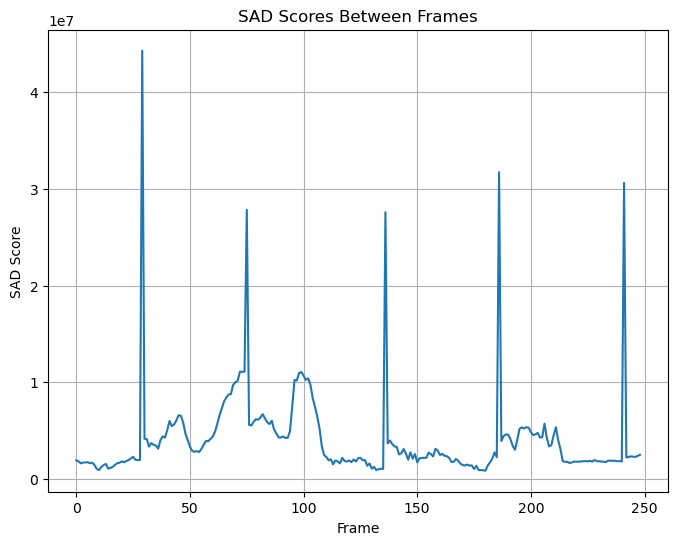

In [5]:
import matplotlib.pyplot as plt

frame_indexes = [i for i in range(n_frames - 1)]

plt.figure(figsize=(8, 6))
plt.plot(frame_indexes, sad_scores)

plt.title('SAD Scores Between Frames')
plt.xlabel('Frame')
plt.ylabel('SAD Score')

plt.grid(True)
plt.show()

In [6]:
from scipy.signal import find_peaks

# the height param is the minimum value a peak must have in order to be considered a valid peak.
sad_peaks, _ = find_peaks(sad_scores, height = (1e7))
sad_peaks

array([ 29,  72,  75,  96,  99, 102, 136, 186, 241], dtype=int64)

***Shot Detection with HD***  
Histogram Differences (HD) is the difference between the histograms of two consecutive video frames. A histogram is a table that contains for each color within a frame the number of pixels that are shaded in that color. This algorithm is good for detecting global content shifts, and is less computationally expensive than pixel-by-pixel comparisons. It is also less prone to false hits, but is also more likely to miss hard cuts.

Here, we separate two frames to be compared into their three color channels. And we sum each difference to get the hd score.

In [7]:
def compute_hd(frame_1, frame_2):
    
    channels_1 = cv2.split(frame_1)
    channels_2 = cv2.split(frame_2)
    
    hd = 0
    for i in range(len(channels_1)):
        # iamge, color channel, mask, buckets, range of values
        hist_1 = cv2.calcHist([channels_1[i]], [0], None, [256], [0, 256])
        hist_2 = cv2.calcHist([channels_2[i]], [0], None, [256], [0, 256])
        hd += np.sum(np.abs(hist_1 - hist_2))
    return hd

hd_scores = [compute_hd(frames[i], frames[i + 1]) for i in range(len(frames) - 1)]

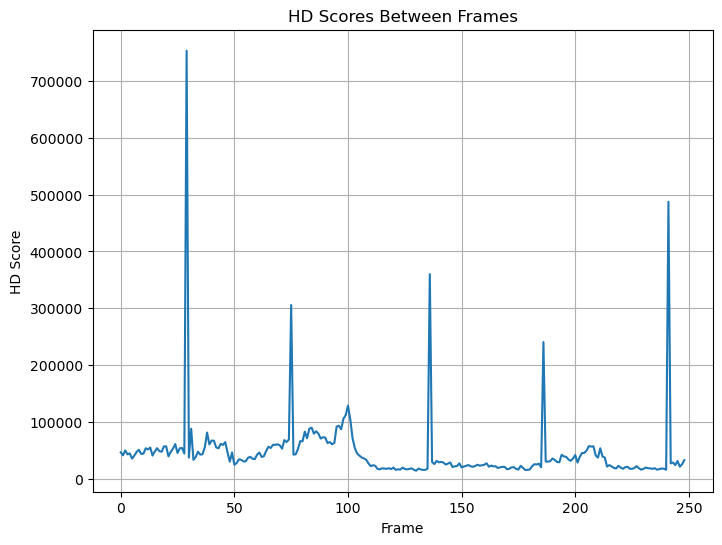

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(frame_indexes, hd_scores)

plt.title('HD Scores Between Frames')
plt.xlabel('Frame')
plt.ylabel('HD Score')

plt.grid(True)
plt.show()

In [9]:
hd_peaks, _ = find_peaks(hd_scores, height = 100_000) 
hd_peaks

array([ 29,  75, 100, 136, 186, 241], dtype=int64)

***Shot Detection with ERC***  
Edge change ratio (ECR) is started with edge detection. The outlines (or edges) of objects are translated into white pixels and everything else is black. The ECR is the sum of new edges and disappearing edges divided by all the edges. New edges are edges that appear in frame2 but not in frame1, and disappearing edges appear in frame1 but not frame2.

The ECR is very sensitive to hard cuts and detects many soft cuts at excellent rates.

In [10]:
def detect_edges(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_frame, 100, 200)
    return edges

In [11]:
def compute_ecr(frame_1, frame_2):
    edges_1 = detect_edges(frame_1)
    edges_2 = detect_edges(frame_2)
    
    new_edges = np.sum((edges_2 == 255) & (edges_1 == 0))
    disappearing_edges = np.sum((edges_1 == 255) & (edges_2 == 0))
    
    total_edges = np.sum(edges_1 == 255) + np.sum(edges_2 == 255)
    
    if total_edges == 0:
        return 0  # avoid division by zero
    
    ecr = (new_edges + disappearing_edges) / total_edges
    return ecr

ecr_scores = [compute_ecr(frames[i], frames[i + 1]) for i in range(len(frames) - 1)]

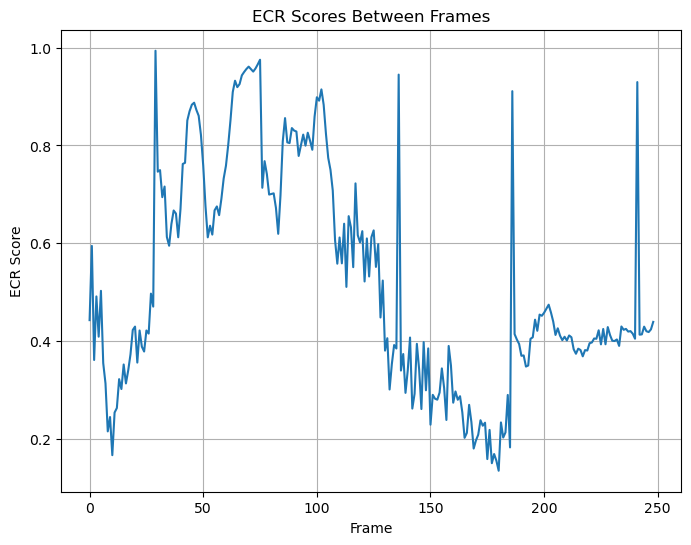

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(frame_indexes, ecr_scores)

plt.title('ECR Scores Between Frames')
plt.xlabel('Frame')
plt.ylabel('ECR Score')

plt.grid(True)
plt.show()

In [13]:
ecr_peaks, _ = find_peaks(ecr_scores, height = 0.4) 
ecr_peaks

array([  1,   3,   5,  20,  22,  25,  27,  29,  31,  33,  37,  46,  53,
        56,  64,  70,  75,  77,  81,  86,  89,  94,  96, 100, 102, 110,
       112, 114, 117, 120, 122, 125, 127, 129, 131, 136, 141, 186, 196,
       198, 202, 206, 209, 211, 222, 224, 226, 228, 232, 234, 236, 238,
       241, 244], dtype=int64)

***Shot Detection with PySceneDetect***  
PySceneDetect is free and open software which serves as a benchmark for scene change detection. It has a recorded F1 score of 0.776	and a 321 fps processing speed. 
It works by using frame intensity.

https://github.com/Breakthrough/PySceneDetect

In [14]:
from scenedetect import detect, ContentDetector

scene_list = detect(video, ContentDetector())
psd_peaks = [scene[0].get_frames() for scene in scene_list]

for i, scene in enumerate(scene_list):
    print('    Scene %2d: Start %s / Frame %d, End %s / Frame %d' % (
        i+1,
        scene[0].get_timecode(), scene[0].get_frames(),
        scene[1].get_timecode(), scene[1].get_frames(),))

    Scene  1: Start 00:00:00.000 / Frame 0, End 00:00:01.200 / Frame 30
    Scene  2: Start 00:00:01.200 / Frame 30, End 00:00:03.040 / Frame 76
    Scene  3: Start 00:00:03.040 / Frame 76, End 00:00:05.480 / Frame 137
    Scene  4: Start 00:00:05.480 / Frame 137, End 00:00:07.480 / Frame 187
    Scene  5: Start 00:00:07.480 / Frame 187, End 00:00:09.680 / Frame 242
    Scene  6: Start 00:00:09.680 / Frame 242, End 00:00:10.000 / Frame 250


***Split and Visualize Video per Algorithm***  
Now, we use the boundaries to slice our videos into shots.

In [15]:
def slice_video_by_boundaries(frames, shot_boundaries):
    chunks = []
    start = 0
    for boundary in shot_boundaries:
        chunks.append(frames[start:boundary])
        start = boundary
    chunks.append(frames[start:])
    return chunks

# Slice video into chunks based on scene_list
hd_chunks  = slice_video_by_boundaries(frames, hd_peaks)
sad_chunks = slice_video_by_boundaries(frames, sad_peaks)
ecr_chunks = slice_video_by_boundaries(frames, ecr_peaks)
psd_chunks = slice_video_by_boundaries(frames, psd_peaks)

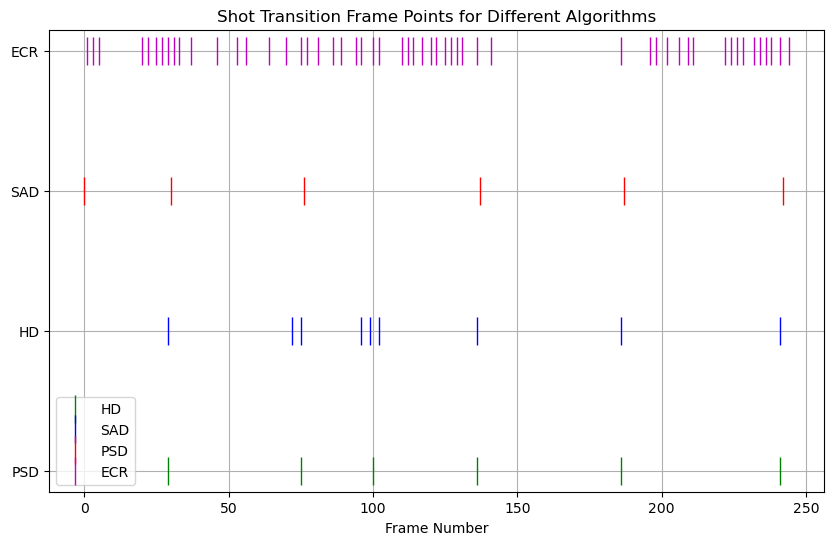

In [16]:
# visualise the chunked time points for all four algorithms
plt.figure(figsize = (10, 6))

plt.plot(hd_peaks,  [1] * len(hd_peaks),  'g|', label='HD',  markersize=20)
plt.plot(sad_peaks, [2] * len(sad_peaks), 'b|', label='SAD', markersize=20)
plt.plot(psd_peaks, [3] * len(psd_peaks), 'r|', label='PSD', markersize=20)
plt.plot(ecr_peaks, [4] * len(ecr_peaks), 'm|', label='ECR', markersize=20)

plt.yticks([1, 2, 3, 4], ['PSD', 'HD', 'SAD', 'ECR'])
plt.xlabel('Frame Number')
plt.title('Shot Transition Frame Points for Different Algorithms')
plt.legend()

plt.grid(True)
plt.show()

### Encoding with VP9  
VP9 is an open-source video codec format developed by Google in 2013 for use mostly on YouTube. It uses techniques like variable block sizes, tile-based parallel decoding, and advanced intra-prediction to achieve high compression efficiency. Even though we use VP9 to standardize work across the shots, this project is codec-independent.

Per chunk encoding is carried out. After which, the chunks are stitched back together.


In [18]:
# make directories for chunked videos
import os

os.makedirs('encoded_hd_chunks',  exist_ok = True)
os.makedirs('encoded_sad_chunks', exist_ok = True)
os.makedirs('encoded_ecr_chunks', exist_ok = True)
os.makedirs('encoded_psd_chunks', exist_ok = True)

In [19]:
# convert chunks to video files
def save_chunk_as_video(frames, output_path, fps=30, codec='vp09'):
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in frames:
        out.write(frame)
    out.release()

# SAD
for i, chunk in enumerate(sad_chunks):
    output_path = f'encoded_sad_chunks/sad_chunk_{i:02d}.mp4'
    output_path = os.path.abspath(output_path)
    save_chunk_as_video(chunk, output_path)

# HD
for i, chunk in enumerate(hd_chunks):
    output_path = f'encoded_hd_chunks/hd_chunk_{i:02d}.mp4'
    output_path = os.path.abspath(output_path)
    save_chunk_as_video(chunk, output_path)

# HD
for i, chunk in enumerate(ecr_chunks):
    output_path = f'encoded_ecr_chunks/ecr_chunk_{i:02d}.mp4'
    output_path = os.path.abspath(output_path)
    save_chunk_as_video(chunk, output_path)

# PSD
for i, chunk in enumerate(psd_chunks):
    output_path = f'encoded_psd_chunks/psd_chunk_{i:02d}.mp4'
    output_path = os.path.abspath(output_path)
    save_chunk_as_video(chunk, output_path)

In [20]:
# stitch together video chunks 
import subprocess

def create_concat_file(chunks_dir, concat_file):
    with open(concat_file, 'w') as f:
        for chunk_file in sorted(os.listdir(chunks_dir)):
            if chunk_file.endswith('.mp4'):
                f.write(f"file '{chunks_dir}/{chunk_file}'\n")

def stitch_chunks(concat_file, output_file):
    command = [
        'ffmpeg', '-f', 'concat', '-safe', '0', '-i', concat_file,
        '-c', 'copy', output_file
    ]
    subprocess.run(command)
    
# Create files to list all the chunks for each type of shot detection
create_concat_file('encoded_hd_chunks',  'hd_concat_list.txt')
create_concat_file('encoded_psd_chunks', 'psd_concat_list.txt')
create_concat_file('encoded_ecr_chunks', 'ecr_concat_list.txt')
create_concat_file('encoded_sad_chunks', 'sad_concat_list.txt')

In [ ]:
# open('stitched_hd_video.mp4',  "w")
# open('stitched_psd_video.mp4', "w")
# open('stitched_ecr_video.mp4', "w")
# open('stitched_sad_video.mp4', "w")

In [ ]:
# print(os.path.abspath('hd_concat_list.txt'))

In [23]:
# Stitch chunks together for each shot detection algorithm
stitch_chunks('hd_concat_list.txt',  'stitched_hd_video.mp4')
# stitch_chunks('psd_concat_list.txt', 'stitched_psd_video.mp4')
# stitch_chunks('ecr_concat_list.txt', 'stitched_ecr_video.mp4')
# stitch_chunks('sad_concat_list.txt', 'stitched_sad_video.mp4')

FileNotFoundError: [WinError 2] The system cannot find the file specified

### Evaluation with VMAF

Finally, we will evaluate 

In [ ]:
# evaluation with vmaf
plus benchmark (unchunked video)

In [ ]:
videos = [
    "video_0.mp4",
    "video_1.mp4",
    "video_2.mp4",
    "video_3.mp4",
    "video_4.mp4",
]